# **User Activity-Based Day Condition Model**

This model helps you understand how your daily activities affect your day. By looking at what you do throughout the day, like exercising, working, relaxing, and sleeping, it can classify your day into one of four categories:
* **Balance Achiever** : Your day is well-rounded with a good mix of work, workout, entertainment, and sleep. You manage to balance different aspects of your life effectively.
* **Stressful Overload** : Your day is dominated by stressful activities, leaving little room for relaxation or sleeping. You may feel overwhelmed and overburdened.
* **Fitness Fanatic** : Your day focuses heavily on physical activities and exercise. You do daily workouts ranging from 30 to 60 minutes and eat a lot to ensure you have enough energy
* **Active Explorer** : Your day is filled with various activities and exploration. You engage in a mix of tasks, often seeking new experiences through traveling, dating, and entertainment activities.

**Key Features**

* **Activity Tracking**: Keeps track of what you do all day.
* **Condition Classification**: Determines if your day is a Balance Achiever, Stressful Overload, Fitness Fanatic, or Active Explorer.
* **Personalization**: Learns your habits and preferences to give you accurate results.
* **Insights and Recommendations**: Gives you tips and advice to help you have better days.

##**Libraries**

* **TensorFlow and Keras**: These are tools for building and training deep learning models. TensorFlow is like the main engine, and Keras is a special tool within TensorFlow that makes it easier to create these models.

* **Scikit-Learn**: This tool helps with getting data ready for learning and splitting it into parts for testing. It does things like changing labels into numbers and dividing up the data for testing.

* **Pandas**: This tool is for working with data in a neat and organized way. It's like a list that helps keep data tidy and easy to work with.

* **NumPy**: NumPy helps with doing math on data. It's good at working with numbers arranged in lists or grids and has lots of math tricks.

* **Seaborn and Matplotlib**: These tools help visualize data. They make it easier to see patterns and relationships in the data by creating pictures.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## **Dataset**

This dataset came from a survey we conducted with our friends and has already been sorted and evaluated manually by us.

In [ ]:
df=pd.read_excel('MOOD TRAK.xlsx')
df.head()

,Time Stamp,Day,Activities,Start,End,Quality,Note
0,2024-05-01 07:00:00,Wednesday,sleep,23:00:00,05:00:00,okay,Bangun pagi untuk sholat subuh.
1,2024-05-01 07:00:00,Wednesday,selfcare,05:00:00,05:30:00,good,"Mandi dan bersiap, air dingin di pagi hari tid..."
2,2024-05-01 07:00:00,Wednesday,eating,05:30:00,06:00:00,good,Sarapan pagi dengan roti bakar dan susu.
3,2024-05-01 07:00:00,Wednesday,workout,06:00:00,07:00:00,excellent,Jogging sekitar kos-kosan. Bertemu banyak anak...
4,2024-05-01 07:00:00,Wednesday,traveling,07:00:00,07:30:00,excellent,"Berangkat ke kampus, perjalanan sekitar 2 km d..."


1. **Time Stamp**: This tells when the activity happened.

2. **Day**: Shows which day of the week it was.

3. **Activities**: Describes what was done, like sleeping or eating.

4. **Start**: Says when the activity began.

5. **End**: Tells when the activity finished.

6. **Quality**: Rates how good the activity was, like okay or excellent.

7. **Note**: Gives extra details or thoughts about the activity.

## **Data Preprocessing**

### **Fixing Columns and Format**

In [ ]:
# Drop 'Note' columns because its not used in this model
df_new=df.drop(columns=['Note'])

# Convert time columns to datetime
df_new['Time Stamp'] = pd.to_datetime(df_new['Time Stamp']).dt.date

# Convert 'Start' and 'End' to datetime
df_new['Start'] = pd.to_datetime(df_new['Start'], format='%H:%M:%S').dt.time
df_new['End'] = pd.to_datetime(df_new['End'], format='%H:%M:%S').dt.time

# Calculate duration
df_new['Duration'] = pd.to_timedelta(df_new['End'].astype(str)) - pd.to_timedelta(df_new['Start'].astype(str))
df_new['Duration'] = df_new['Duration'].apply(lambda x: x + pd.Timedelta(days=1) if x.days < 0 else x)
df_new['Duration'] = df_new['Duration'].apply(lambda x: int(pd.to_timedelta(x).total_seconds() // 60)) #Hour to Minutes

df_new

,Time Stamp,Day,Activities,Start,End,Quality,Duration
0,2024-05-01,Wednesday,sleep,23:00:00,05:00:00,okay,360
1,2024-05-01,Wednesday,selfcare,05:00:00,05:30:00,good,30
2,2024-05-01,Wednesday,eating,05:30:00,06:00:00,good,30
3,2024-05-01,Wednesday,workout,06:00:00,07:00:00,excellent,60
4,2024-05-01,Wednesday,traveling,07:00:00,07:30:00,excellent,30
...,...,...,...,...,...,...,...
1215,2024-08-06,Tuesday,entertainment,17:45:00,19:00:00,okay,75
1216,2024-08-06,Tuesday,eating,19:00:00,19:30:00,okay,30
1217,2024-08-06,Tuesday,study,19:30:00,21:00:00,okay,90
1218,2024-08-06,Tuesday,dating,21:00:00,23:00:00,okay,120


### **Grouping Data**

To transform the dataset, the "Activities" column was converted into individual columns for each activity, creating a pivot table where each row represents a date and each column represents a specific activity.

In [ ]:
# Aggregate daily data
daily_summary = df_new.groupby(['Time Stamp', 'Activities']).agg({'Duration': 'sum'}).reset_index()

daily_summary_pivot = daily_summary.pivot(index='Time Stamp', columns='Activities', values='Duration').fillna(0)
daily_summary_pivot.reset_index(inplace=True)
daily_summary_pivot

Activities,Time Stamp,dating,eating,entertainment,selfcare,sleep,study,traveling,work,workout
0,2024-05-01,0.0,105.0,165.0,45.0,360.0,630.0,135.0,0.0,60.0
1,2024-05-02,260.0,135.0,0.0,45.0,300.0,480.0,145.0,0.0,75.0
2,2024-05-03,0.0,120.0,180.0,60.0,480.0,480.0,60.0,0.0,60.0
3,2024-05-04,210.0,90.0,300.0,45.0,795.0,0.0,0.0,0.0,0.0
4,2024-05-05,150.0,85.0,465.0,0.0,300.0,240.0,200.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
93,2024-08-02,120.0,120.0,75.0,30.0,450.0,90.0,75.0,465.0,45.0
94,2024-08-03,120.0,120.0,75.0,30.0,450.0,90.0,75.0,435.0,45.0
95,2024-08-04,120.0,120.0,75.0,30.0,420.0,90.0,75.0,435.0,45.0
96,2024-08-05,120.0,120.0,75.0,30.0,420.0,90.0,75.0,465.0,45.0


### **Generate Data**

Because the dataset from survey is limited (97 days) and for classification model need **SO MUCH** data, so we generate data using functions. This function generate data based on limited duration for each activity and the sum up of the duration is exactly 1440 minutes (24 hours).

In [ ]:
# Setting the activity duration limits
activity_limits = {
    "dating": (0, 180),
    "eating": (60, 90),
    "entertainment": (0, 180),
    "selfcare": (30, 90),
    "sleep": (180, 600),
    "study": (0, 600),
    "traveling": (30, 120),
    "work": (60, 600),
    "workout": (0, 90)
}

def generate_random_row(limits):
    row = {}
    total = 0
    for activity, (low, high) in limits.items():
        duration = np.random.randint(low, high + 1)
        row[activity] = duration
        total += duration

    # Adjust the row to make the total exactly 1440 minutes
    if total != 1440:
        for activity in limits:
            if total < 1440:
                add_duration = min(limits[activity][1] - row[activity], 1440 - total)
                row[activity] += add_duration
                total += add_duration
                if total == 1440:
                    break
            elif total > 1440:
                remove_duration = min(row[activity] - limits[activity][0], total - 1440)
                row[activity] -= remove_duration
                total -= remove_duration
                if total == 1440:
                    break

    return row
# Generate 10,000 new rows
new_rows = []
for _ in range(10000):
    new_row = generate_random_row(activity_limits)
    new_row['Time Stamp'] = 'Generated'
    new_rows.append(new_row)

# Convert the list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows)
daily_summary_pivot = pd.concat([daily_summary_pivot, new_rows_df], ignore_index=True)
daily_summary_pivot.tail()

,Time Stamp,dating,eating,entertainment,selfcare,sleep,study,traveling,work,workout
10093,Generated,0.0,60.0,9.0,86.0,531.0,434.0,30.0,280.0,10.0
10094,Generated,0.0,60.0,0.0,30.0,180.0,494.0,71.0,537.0,68.0
10095,Generated,168.0,68.0,1.0,77.0,575.0,188.0,55.0,266.0,42.0
10096,Generated,0.0,60.0,17.0,63.0,347.0,246.0,45.0,590.0,72.0
10097,Generated,0.0,60.0,6.0,79.0,376.0,282.0,40.0,544.0,53.0


### **Setting Threshold to Classify**

Since classification models require labels to operate, and the dataset lacks labels, we classified using a Python function based on the threshold for each activity obtained from observing human daily schedules.

In [ ]:
# Define thresholds
sleep_threshold = 7 * 60
study_threshold = 8 * 60
work_threshold = 8 * 60
selfcare_threshold = 1 * 60
traveling_threshold = 1 * 60
workout_threshold = 1 * 60
entertainment_threshold = 1 * 60
eating_threshold = 1 * 60

def classify_day(row):
    sleep = row.get('sleep', 0)
    study = row.get('study', 0)
    dating = row.get('dating', 0)
    work = row.get('work', 0)
    selfcare = row.get('selfcare', 0)
    traveling = row.get('traveling', 0)
    workout = row.get('workout', 0)
    entertainment = row.get('entertainment', 0)
    eating = row.get('eating', 0)

    if sleep < sleep_threshold and work > work_threshold:
        return 'Stressful Overload'
    elif sleep < sleep_threshold and study > study_threshold:
        return 'Stressful Overload'
    elif workout > workout_threshold and eating > eating_threshold:
        return 'Fitness Fanatic'
    elif traveling > traveling_threshold and entertainment > entertainment_threshold:
        return 'Active Explorer'
    else:
        return 'Balanced Achiever'
# Apply classification
daily_summary_pivot['Day_Condition'] = daily_summary_pivot.apply(classify_day, axis=1)
daily_summary_pivot

,Time Stamp,dating,eating,entertainment,selfcare,sleep,study,traveling,work,workout,Day_Condition
0,2024-05-01,0.0,105.0,165.0,45.0,360.0,630.0,135.0,0.0,60.0,Stressful Overload
1,2024-05-02,260.0,135.0,0.0,45.0,300.0,480.0,145.0,0.0,75.0,Fitness Fanatic
2,2024-05-03,0.0,120.0,180.0,60.0,480.0,480.0,60.0,0.0,60.0,Balanced Achiever
3,2024-05-04,210.0,90.0,300.0,45.0,795.0,0.0,0.0,0.0,0.0,Balanced Achiever
4,2024-05-05,150.0,85.0,465.0,0.0,300.0,240.0,200.0,0.0,0.0,Active Explorer
...,...,...,...,...,...,...,...,...,...,...,...
10093,Generated,0.0,60.0,9.0,86.0,531.0,434.0,30.0,280.0,10.0,Balanced Achiever
10094,Generated,0.0,60.0,0.0,30.0,180.0,494.0,71.0,537.0,68.0,Stressful Overload
10095,Generated,168.0,68.0,1.0,77.0,575.0,188.0,55.0,266.0,42.0,Balanced Achiever
10096,Generated,0.0,60.0,17.0,63.0,347.0,246.0,45.0,590.0,72.0,Stressful Overload


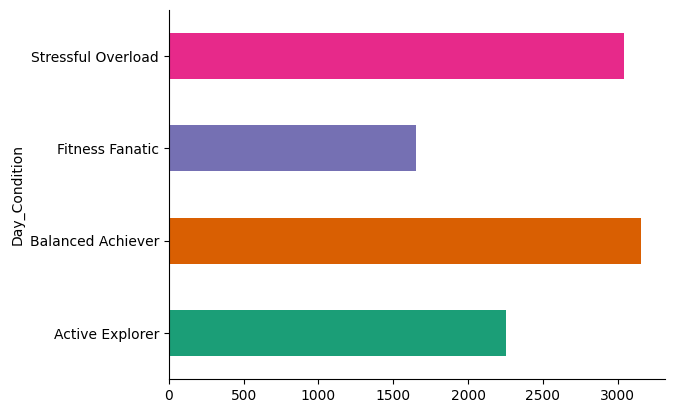

In [ ]:
daily_summary_pivot.groupby('Day_Condition').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Then we encode the labels to integer before modelling.

In [ ]:
# Encode 'Day_Condition' column to integers
label_encoder = LabelEncoder()
daily_summary_pivot['Day_Condition'] = label_encoder.fit_transform(daily_summary_pivot['Day_Condition'])
daily_summary_pivot

,Time Stamp,dating,eating,entertainment,selfcare,sleep,study,traveling,work,workout,Day_Condition
0,2024-05-01,0.0,105.0,165.0,45.0,360.0,630.0,135.0,0.0,60.0,3
1,2024-05-02,260.0,135.0,0.0,45.0,300.0,480.0,145.0,0.0,75.0,2
2,2024-05-03,0.0,120.0,180.0,60.0,480.0,480.0,60.0,0.0,60.0,1
3,2024-05-04,210.0,90.0,300.0,45.0,795.0,0.0,0.0,0.0,0.0,1
4,2024-05-05,150.0,85.0,465.0,0.0,300.0,240.0,200.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
10093,Generated,0.0,60.0,9.0,86.0,531.0,434.0,30.0,280.0,10.0,1
10094,Generated,0.0,60.0,0.0,30.0,180.0,494.0,71.0,537.0,68.0,3
10095,Generated,168.0,68.0,1.0,77.0,575.0,188.0,55.0,266.0,42.0,1
10096,Generated,0.0,60.0,17.0,63.0,347.0,246.0,45.0,590.0,72.0,3


* 0: Active Explorer
* 1: Balanced Achiever
* 2: Fitness Fanatic
* 3: Stressful Overload

## **Data Modelling**

### **Feature Selector**

In [ ]:
# Prepare data for model
X = daily_summary_pivot.drop(columns=['Time Stamp', 'Day_Condition']).values
y = daily_summary_pivot['Day_Condition'].values

# Split data into train and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split test data into validation and test (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Check the shapes of the datasets
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (8078, 9) (8078,)
Validation set shape: (1010, 9) (1010,)
Test set shape: (1010, 9) (1010,)


### **Model Building**

In [ ]:
# Define the model
model = Sequential([
    Dense(128,activation='relu',input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile the model with adam optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val,y_val), batch_size=32, verbose=1)

Epoch 1/100
253/253 [==============================] - 4s 6ms/step - loss: 2.0443 - accuracy: 0.6977 - val_loss: 0.6500 - val_accuracy: 0.7901
Epoch 2/100
253/253 [==============================] - 1s 4ms/step - loss: 0.6752 - accuracy: 0.8054 - val_loss: 0.4825 - val_accuracy: 0.8535
Epoch 3/100
253/253 [==============================] - 1s 3ms/step - loss: 0.4563 - accuracy: 0.8477 - val_loss: 0.5231 - val_accuracy: 0.8287
Epoch 4/100
253/253 [==============================] - 1s 3ms/step - loss: 0.4957 - accuracy: 0.8462 - val_loss: 0.4348 - val_accuracy: 0.8455
Epoch 5/100
253/253 [==============================] - 1s 3ms/step - loss: 0.4340 - accuracy: 0.8543 - val_loss: 0.5100 - val_accuracy: 0.8079
Epoch 6/100
253/253 [==============================] - 1s 3ms/step - loss: 0.3471 - accuracy: 0.8778 - val_loss: 0.3253 - val_accuracy: 0.8713
Epoch 7/100
253/253 [==============================] - 1s 3ms/step - loss: 0.3046 - accuracy: 0.8898 - val_loss: 0.2420 - val_accuracy: 0.8990

## **Model Evaluation**

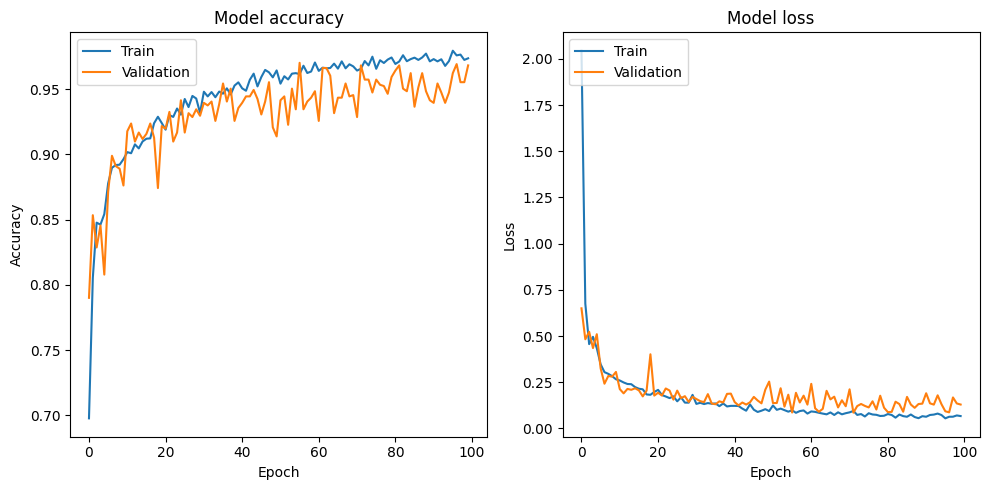

In [ ]:
# Plot training history
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Predict the probabilities for each class
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate a classification report
report = classification_report(y_test, y_pred)
print(report)

32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       208
           1       0.97      0.98      0.97       344
           2       0.96      0.95      0.95       153
           3       0.97      0.98      0.98       305

    accuracy                           0.97      1010
   macro avg       0.97      0.97      0.97      1010
weighted avg       0.97      0.97      0.97      1010



## **Convert Model**

In [ ]:
model.save('day_condition_model.h5')

In [ ]:
# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)